# Simulation Settings

In [1]:
import os
import numpy as np
from cideMOD import (
    CellParser,
    ErrorCheck,
    NDProblem,
    Problem,
    SolverCrashed,
    Trigger,
    init_results_folder,
    ModelOptions,
)

In [2]:
overwrite = False
case = "Xu_2015"
data_path = f"../../data/data_{case}"
params = "params.json"

C_rates = [0.5, 1, 2] # Positive == discharge

T_0 = 273 + 20 # temperature in Kelvin

v_min = 2.1 # Cut-off voltage

timesteps = [10, 5, 5, 1] # int, float or List[int,float] of length len(C_rates)


In [3]:
cell = CellParser(params, data_path=data_path)
results = dict()

# Experimental

In [4]:
results["Experimental"] = dict()
assert "results" in cell.dic, f"No experimental results specified in {os.path.join(data_path, params)}"
for C_rate in C_rates:
    if f"{C_rate:.3g}C" in cell.dic["results"]:
        results["Experimental"][f"{C_rate:.3g}C"] = dict()
        for key, dic in cell.dic["results"][f"{C_rate:.3g}C"].items():
            results["Experimental"][f"{C_rate:.3g}C"][key] = dic
            if dic['source'] == 'file':
                path = os.path.join(data_path, dic['value'])
                assert os.path.exists(path), f"Path to experimental data '{path}' doesn't exists"
                arr = np.genfromtxt( path, delimiter=' ')
            else:
                raise ValueError(f"Unrecognize source file of type '{dic['source']}'. Available options: 'file'")
            results["Experimental"][f"{C_rate:.3g}C"][key]['array'] = arr

# P2D

In [ ]:
model_options = ModelOptions(mode='P2D', solve_thermal = True, clean_on_exit=False)

results["P2D"] = dict()
for i, C_rate in enumerate(C_rates):
    save_path = init_results_folder(
        f"{case}_{model_options.mode}_{C_rate:.3g}C", overwrite=overwrite, copy_files=[f"{data_path}/{params}", model_options.dict()], filenames=['params', 'simulation_options']
    )

    problem = Problem(cell, model_options, save_path=save_path)
    problem.set_cell_state(1, T_0, T_0)
    problem.setup()
    I_app = -C_rate * problem.Q
    t_f = 3600 /abs(C_rate)*1.25
    min_step = timesteps if not isinstance(timesteps, list) else timesteps[i]

    status = problem.solve_ie(min_step=min_step, i_app=I_app, t_f=t_f, store_delay=10, adaptive=True, triggers=[Trigger(v_min, "v")])

    results["P2D"][f"{C_rate:.3g}C"] = { key : problem.WH.get_global_variable(key) for key in ['time', *problem.WH.global_vars.keys()] }


# P4D

In [ ]:
read_results = False
model_options = ModelOptions(mode='P4D', solve_thermal = True, clean_on_exit=False)
results["P4D"] = dict()
for i, C_rate in enumerate(C_rates):
    if read_results and os.path.exists(f"results_{case}_{model_options.mode}_{C_rate:.3g}C/voltage.txt"):
        results["P4D"][f"{C_rate:.3g}C"] = dict()
        for key in ['voltage', 'capacity', 'temperature']:
            path = f"results_{case}_{model_options.mode}_{C_rate:.3g}C/{key}.txt"
            if os.path.exists(path):
                arr = np.loadtxt(path)
                results["P4D"][f"{C_rate:.3g}C"][key] = arr[:,1]
                if 'time' not in results["P4D"][f"{C_rate:.3g}C"]:
                    results["P4D"][f"{C_rate:.3g}C"]['time'] = arr[:,0]
        continue

    save_path = init_results_folder(
        f"{case}_{model_options.mode}_{C_rate:.3g}C", overwrite=overwrite, 
        copy_files=[f"{data_path}/{params}", model_options.dict()], filenames=['params', 'simulation_options']
    )

    problem = NDProblem(cell, model_options, save_path=save_path)
    problem.set_cell_state(1, T_0, T_0)
    problem.setup()
    I_app = -C_rate * problem.Q
    t_f = 3600 /abs(C_rate)*1.25
    min_step = timesteps if not isinstance(timesteps, list) else timesteps[i]

    status = problem.solve_ie( min_step=min_step, i_app=I_app, t_f=t_f, store_delay=1, adaptive=True, triggers=[Trigger(v_min, "v")] )

    results["P4D"][f"{C_rate:.3g}C"] = { key : problem.WH.get_global_variable(key) for key in ['time', *problem.WH.global_vars.keys()] }

# Compare results

In [6]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

plot_dict = {
    "0.5C" : {
        "Experimental": {'fnc': 'scatter', 'marker': 'o', 'c': '#76B64A', 's': 5, 'label' : 'Experimental 0.5C', 'zorder': 10},
        "P2D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#FFBF00', 'label' : 'cideMOD 0.5C', 'zorder': 20},
        "P4D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#F69200', 'label' : 'P4D 0.5C', 'zorder': 30}
    },
    "1C" : {
        "Experimental": {'fnc': 'scatter', 'marker': 's', 'c': 'k', 's': 5, 'label' : 'Experimental 1C', 'zorder': 10},
        "P2D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#FF0000', 'label' : 'cideMOD 1C', 'zorder': 20},
        "P4D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#D31FAC', 'label' : 'P4D 1C', 'zorder': 30},
        # "Xu": {'fnc': 'plot', 'linestyle' : '--', 'c': '#D31FAC', 'label' : 'Xu sim. 0.5C', 'zorder': 15}
    },
    "2C" : {
        "Experimental": {'fnc': 'scatter', 'marker': '^', 'c': '#3D6CC2', 's': 5, 'label' : 'Experimental 2C', 'zorder': 10},
        "P2D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#C51919', 'label' : 'cideMOD 2C', 'zorder': 20},
        "P4D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#CF580F', 'label' : 'P4D 2C', 'zorder': 30}
    },
    "default": {
        "Experimental": {'fnc': 'scatter', 'marker': 'o', 'c': None, 's': 5, 'label' : 'Experimental {C_rate:3g}C', 'zorder': 10},
        "P2D": {'fnc': 'plot', 'linestyle' : '-', 'c': None, 'label' : 'cideMODc {C_rate:3g}C', 'zorder': 20},
        "P4D": {'fnc': 'plot', 'linestyle' : '-', 'c': None, 'label' : 'P4D {C_rate:3g}C', 'zorder': 30}
    }
}
table_dict_voltage={}
table_dict_temperature={}


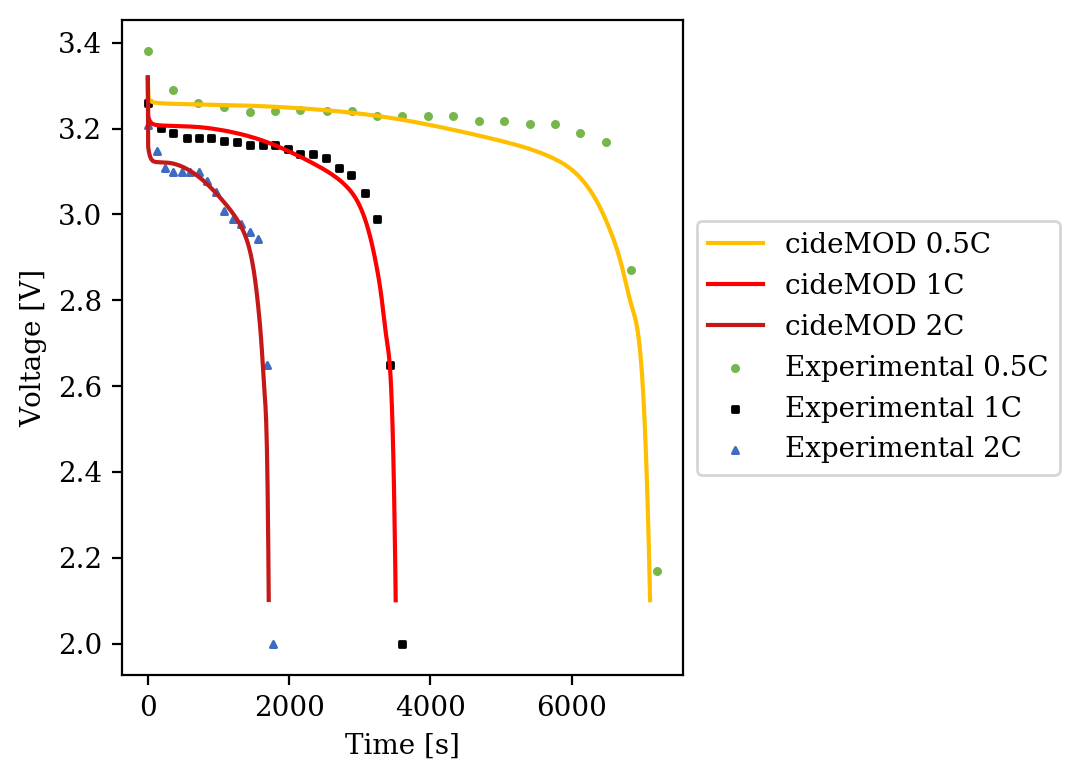

In [7]:
# Plot voltage results over time
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
for C_rate in C_rates:
    table_dict_voltage[f"{C_rate:.3g}C"]={}
    plot_config = plot_dict.get(f"{C_rate:.3g}C",  plot_dict["default"])
    for dataset, data_dict in plot_config.items():
        if dataset not in results or f"{C_rate:.3g}C" not in results[dataset]:
            continue
        if dataset in ['Experimental']:
            arr = results[dataset][f"{C_rate:.3g}C"]['voltage']['array']
            X, Y = arr[:,0], arr[:,1]
        else:
            X = results[dataset][f"{C_rate:.3g}C"]['time']
            Y = results[dataset][f"{C_rate:.3g}C"]['voltage']

        kwargs = {k:v for k,v in data_dict.items() if k not in [ 'fnc', 'label']}
        label = data_dict.get('label', f'{dataset}_{C_rate:3g}C').format(C_rate=C_rate)
        if 'fnc' not in data_dict or data_dict['fnc'] == 'plot':
            ax.plot(X, Y, label = label, **kwargs)
        elif data_dict['fnc'] == 'scatter':
            ax.scatter(X, Y, label = label, **kwargs)
        else:
            ax.__getattr__(data_dict['fnc'])(X, Y, label = label, **kwargs)
        table_dict_voltage[f"{C_rate:.3g}C"][dataset]=[X,Y]
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

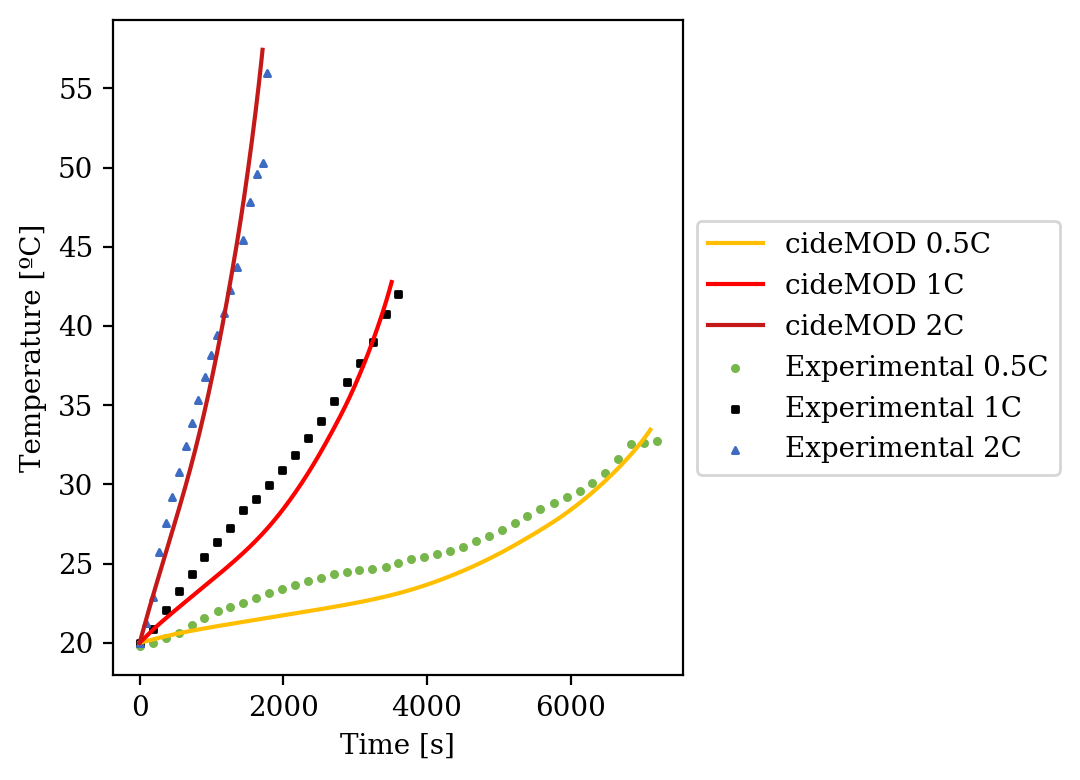

In [8]:
# Plot temperature results over time
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
for C_rate in C_rates:
    plot_config = plot_dict.get(f"{C_rate:.3g}C",  plot_dict["default"])
    table_dict_temperature[f"{C_rate:.3g}C"]={}
    for dataset, data_dict in plot_config.items():
        if dataset not in results or f"{C_rate:.3g}C" not in results[dataset]:
            continue
        if dataset in ['Experimental']:
            arr = results[dataset][f"{C_rate:.3g}C"]['temperature']['array']
            X, Y = arr[:,0], arr[:,1]
        else:
            X = results[dataset][f"{C_rate:.3g}C"]['time']
            Y = np.array(results[dataset][f"{C_rate:.3g}C"]['temperature'], dtype = float) - 273 # ºC

        kwargs = {k:v for k,v in data_dict.items() if k not in [ 'fnc', 'label']}
        label = data_dict.get('label', f'{dataset}_{C_rate:3g}C').format(C_rate=C_rate)
        if 'fnc' not in data_dict or data_dict['fnc'] == 'plot':
            ax.plot(X, Y, label = label, **kwargs)
        elif data_dict['fnc'] == 'scatter':
            ax.scatter(X, Y, label = label, **kwargs)
        else:
            ax.__getattr__(data_dict['fnc'])(X, Y, label = label, **kwargs)
        table_dict_temperature[f"{C_rate:.3g}C"][dataset]=[X,Y]
        
ax.set_xlabel("Time [s]")
ax.set_ylabel("Temperature [ºC]")
# ax.legend(loc="best") 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [9]:
from scipy.interpolate import interp1d
from tabulate import tabulate
import numpy

table_list_v = []
table_list_t = []

for key, item in table_dict_voltage.items():
    real_x, real_y = table_dict_voltage[key]["Experimental"]
    results_x_y = [table_dict_voltage[key][k] for k in item.keys() if k != "Experimental"]
    results_tag = [k for k in item.keys() if k != "Experimental"]
    real = interp1d(real_x, real_y, bounds_error=False)
    results = [interp1d(res[0], res[1], bounds_error=False) for res in results_x_y]

    time = numpy.linspace(
        max([real_x[0]]+[res[0][0] for res in results_x_y]), 
        min([real_x[-1]]+[res[0][-1] for res in results_x_y]), 
        100) 

    # plot the RMSE over time
    for result, tag in zip(results, results_tag):
        rmse = numpy.sqrt(numpy.sum((real(time)-result(time))**2)/len(time))*1e3
        peak = numpy.abs(real(time)-result(time)).max()*1e3
        name = f"{tag} {key}"
        table_list_v.append([name, rmse, peak])

for key, item in table_dict_temperature.items():
    real_x, real_y = table_dict_temperature[key]["Experimental"]
    results_x_y = [table_dict_temperature[key][k] for k in item.keys() if k != "Experimental"]
    results_tag = [k for k in item.keys() if k != "Experimental"]
    real = interp1d(real_x, real_y, bounds_error=False)
    results = [interp1d(res[0], res[1], bounds_error=False) for res in results_x_y]

    time = numpy.linspace(
        max([real_x[0]]+[res[0][0] for res in results_x_y]), 
        min([real_x[-1]]+[res[0][-1] for res in results_x_y]), 
        100) 

    # plot the RMSE over time
    for result, tag in zip(results, results_tag):
        rmse = numpy.sqrt(numpy.sum((real(time)-result(time))**2)/len(time))
        peak = numpy.abs(real(time)-result(time)).max()
        name = f"{tag} {key}"
        table_list_t.append([name, rmse, peak])

print(tabulate(table_list_v, headers = ['', "RMSE (mV)", "Peak error (mV)"], floatfmt=".0f"))
print(tabulate(table_list_t, headers = ['', "RMSE (ºC)", "Peak error (ºC)"], floatfmt=".2f"))

            RMSE (mV)    Peak error (mV)
--------  -----------  -----------------
P2D 0.5C           62                261
P2D 1C             39                236
P2D 2C             19                 58
            RMSE (ºC)    Peak error (ºC)
--------  -----------  -----------------
P2D 0.5C         1.39               2.08
P2D 1C           1.82               2.69
P2D 2C           2.33               7.14
